In [18]:
import os
import shutil
import time
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as T
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader

# 1. Configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# 2. Reproducibility
def seed_everything(seed=42):
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
seed_everything(42)

# 3. Physics-Aware Normalization Helpers
# These are crucial for applying the pattern in "Real World" pixel space (0-1)
class ReIDNormalize(nn.Module):
    def __init__(self, mean, std):
        super(ReIDNormalize, self).__init__()
        self.register_buffer('mean', torch.Tensor(mean).view(1, 3, 1, 1))
        self.register_buffer('std', torch.Tensor(std).view(1, 3, 1, 1))
    def forward(self, tensor): return (tensor - self.mean) / self.std

class ReIDUnNormalize(nn.Module):
    def __init__(self, mean, std):
        super(ReIDUnNormalize, self).__init__()
        self.register_buffer('mean', torch.Tensor(mean).view(1, 3, 1, 1))
        self.register_buffer('std', torch.Tensor(std).view(1, 3, 1, 1))
    def forward(self, tensor): return (tensor * self.std) + self.mean

# Define Standard ImageNet Normalization Layers
norm_layer = ReIDNormalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]).to(device)
unnorm_layer = ReIDUnNormalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]).to(device)

Using device: cuda


In [19]:
# --- 1. DATA CONFIGURATION ---
DATA_ROOT = './Market-1501-v15.09.15'  # Ensure this path is correct

transform_test = transforms.Compose([
    transforms.Resize((256, 128), interpolation=3),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

image_datasets = {
    'gallery': datasets.ImageFolder(os.path.join(DATA_ROOT, 'bounding_box_test'), transform_test),
    'query': datasets.ImageFolder(os.path.join(DATA_ROOT, 'query'), transform_test)
}

dataloaders = {x: DataLoader(image_datasets[x], batch_size=32, shuffle=False, num_workers=2) 
               for x in ['gallery', 'query']}

# --- 2. VICTIM MODEL (ResNet-50 IDE) ---
class ModelB_ResNet50(nn.Module):
    def __init__(self, num_classes=751):
        super(ModelB_ResNet50, self).__init__()
        self.model = models.resnet50(pretrained=True)
        self.in_features = self.model.fc.in_features
        self.model.fc = nn.Linear(self.in_features, num_classes)
        
    def forward(self, x): return self.model(x)

    def get_embedding(self, x):
        # Extract features before the final layer
        x = self.model.conv1(x)
        x = self.model.bn1(x)
        x = self.model.relu(x)
        x = self.model.maxpool(x)
        x = self.model.layer1(x)
        x = self.model.layer2(x)
        x = self.model.layer3(x)
        x = self.model.layer4(x)
        x = self.model.avgpool(x)
        x = torch.flatten(x, 1)
        return x

# Initialize and Load Weights
model_b = ModelB_ResNet50(num_classes=751).to(device)
if os.path.exists('model_b_market1501.pth'):
    model_b.load_state_dict(torch.load('model_b_market1501.pth'))
    print("Victim Model Loaded Successfully.")
else:
    print("Error: 'model_b_market1501.pth' not found. Please train the model first.")

Victim Model Loaded Successfully.


C:\Users\Uday Raj\AppData\Local\Temp\ipykernel_19088\109224503.py:45: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_b.load_state_dict(torch.load('model_b_market1501.pt

In [20]:
def get_images_by_pid(dataset, target_pid, max_images=50):
    found_images = []
    for i in range(len(dataset)):
        path, _ = dataset.imgs[i]
        filename = os.path.basename(path)
        pid = int(filename.split('_')[0])
        if pid == target_pid:
            img_tensor = dataset[i][0].unsqueeze(0)
            found_images.append(img_tensor)
            if len(found_images) >= max_images: break
    if len(found_images) == 0: return None
    return torch.cat(found_images, dim=0).to(device)

def extract_features_robust(model, dataloader, device):
    model.eval()
    features = []
    with torch.no_grad():
        for imgs, _ in dataloader:
            imgs = imgs.to(device)
            outputs = model.get_embedding(imgs)
            fnorm = torch.norm(outputs, p=2, dim=1, keepdim=True)
            outputs = outputs.div(fnorm.expand_as(outputs))
            features.append(outputs.cpu())
    return torch.cat(features, dim=0)

def get_id_and_cam(dataset):
    pids, camids = [], []
    for path, _ in dataset.imgs:
        filename = os.path.basename(path)
        pids.append(int(filename.split('_')[0]))
        camids.append(int(filename.split('_')[1][1]))
    return np.array(pids), np.array(camids)

def evaluate_attack_full_metrics(model, dataloaders, pattern, mask, target_pid, query_images, device):
    print(f"\n--- Calculating Table 2 Metrics for PID {target_pid} ---")
    
    # 1. Gallery Features
    g_feats = extract_features_robust(model, dataloaders['gallery'], device)
    g_pids, g_camids = get_id_and_cam(dataloaders['gallery'].dataset)
    
    # 2. Prepare Queries
    with torch.no_grad():
        q_raw = unnorm_layer(query_images.to(device))
        
        # Original
        q_clean_batch = norm_layer(q_raw)
        
        # Adversarial
        q_adv_raw = q_raw + (pattern * mask)
        q_adv_raw.clamp_(0, 1)
        q_adv_batch = norm_layer(q_adv_raw)

    model.eval()
    with torch.no_grad():
        q_feat_clean = torch.nn.functional.normalize(model.get_embedding(q_clean_batch), p=2, dim=1)
        q_feat_adv = torch.nn.functional.normalize(model.get_embedding(q_adv_batch), p=2, dim=1)

    # 3. Metric Calculation Helper
    def calc_metrics_batch(q_feats):
        # Compute Cosine Similarity Matrix
        distmat = torch.mm(q_feats, g_feats.t())
        distmat = distmat.cpu().numpy()
        
        cmc_scores = []
        ap_scores = []
        similarity_scores = [] # For SS
        
        for i in range(q_feats.size(0)):
            # Get similarities for this query
            sims = distmat[i]
            # Sort descending (highest sim first)
            indices = np.argsort(sims)[::-1]
            
            # Find matches
            matches = (g_pids[indices] == target_pid).astype(np.int32)
            
            # SS: Average similarity of the Top-1 Correct Match
            # (Approximation of "Similarity Score" from paper)
            if matches.sum() > 0:
                # Find index of first True Positive
                first_match_idx = np.where(matches == 1)[0][0]
                similarity_scores.append(sims[indices[first_match_idx]])
            else:
                similarity_scores.append(0.0)

            # CMC
            if matches.sum() == 0: continue
            cmc = matches.cumsum()
            cmc[cmc > 1] = 1
            cmc_scores.append(cmc[:10])
            
            # mAP
            num_rel = matches.sum()
            tmp_cmc = matches.cumsum()
            tmp_cmc = [x / (j + 1.) for j, x in enumerate(tmp_cmc)]
            tmp_cmc = np.asarray(tmp_cmc) * matches
            ap_scores.append(tmp_cmc.sum() / num_rel)

        # Average over batch
        all_cmc = np.mean(cmc_scores, axis=0)
        mean_ap = np.mean(ap_scores)
        mean_ss = np.mean(similarity_scores)
        
        return {
            'rank-1': all_cmc[0],
            'rank-5': all_cmc[4],
            'rank-10': all_cmc[9],
            'mAP': mean_ap,
            'ss': mean_ss
        }

    metrics_clean = calc_metrics_batch(q_feat_clean.cpu())
    metrics_adv = calc_metrics_batch(q_feat_adv.cpu())
    
    return metrics_clean, metrics_adv

In [21]:
class AdvPatternAttack_Chest:
    def __init__(self, model, device, lr=0.05):
        self.model = model
        self.device = device
        self.lr = lr
        self.model.eval()
        self.jitter = T.Compose([T.RandomAffine(degrees=0, translate=(0.05, 0.05), scale=(0.95, 1.05))])

    def generate_evading_pattern(self, adversary_images_norm, num_steps=2000):
        print(f"--- Starting CHEST EVADING Attack ({num_steps} steps) ---")
        with torch.no_grad():
            clean_images = unnorm_layer(adversary_images_norm)
            clean_images.clamp_(0, 1)

        # Standard Chest Mask (Paper Exact)
        mask = torch.zeros((1, 3, 256, 128)).to(self.device)
        mask[:, :, 60:160, 20:108] = 1.0 
        
        delta = torch.rand((1, 3, 256, 128)).to(self.device)
        delta.requires_grad = True
        optimizer = optim.Adam([delta], lr=self.lr)
        scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[1000], gamma=0.1)
        cosine_loss = nn.CosineEmbeddingLoss(margin=0.0)
        
        for step in range(num_steps):
            optimizer.zero_grad()
            patch = delta * mask
            jit_patch = self.jitter(patch)
            adv_images = clean_images + jit_patch
            adv_images.clamp_(0, 1)
            
            features = self.model.get_embedding(norm_layer(adv_images))
            
            # Minimize Similarity (Target = -1)
            f1 = features
            f2 = torch.roll(features, shifts=1, dims=0)
            target = torch.ones(f1.size(0)).to(self.device) * -1
            loss = cosine_loss(f1, f2, target)
            
            loss.backward()
            optimizer.step()
            scheduler.step()
            with torch.no_grad(): delta.clamp_(0, 1)
            
            if step % 500 == 0: print(f"Step {step}, Loss: {loss.item():.4f}")
                
        return delta.detach(), mask

Running Full Table 2 Replication on PID 3...
--- Starting CHEST EVADING Attack (2000 steps) ---
Step 0, Loss: 0.8550
Step 500, Loss: 0.7040
Step 1000, Loss: 0.6472
Step 1500, Loss: 0.6909


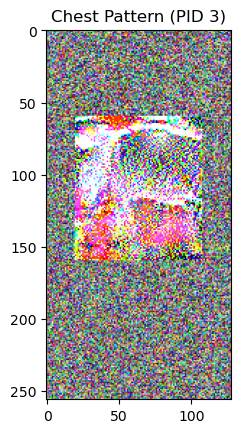


--- Calculating Table 2 Metrics for PID 3 ---

Table 2. Digital-environment attack results (Replicated for PID 3)
Model    Dataset         rank-1     rank-5     rank-10    mAP        ss        
--------------------------------------------------------------------------------
B        Original        100.0%      100.0%      100.0%      55.9%      0.960
B        Attack (TS)     0.0%      0.0%      0.0%      0.3%      0.630


In [22]:
# --- EXECUTE EVADING ATTACK & PRINT TABLE 2 ---
TARGET_PID = 3 # The vulnerable target

print(f"Running Full Table 2 Replication on PID {TARGET_PID}...")

# 1. Get Data
gs_imgs = get_images_by_pid(dataloaders['gallery'].dataset, TARGET_PID)
ts_imgs = get_images_by_pid(dataloaders['query'].dataset, TARGET_PID)

if gs_imgs is not None and ts_imgs is not None:
    # 2. Train Pattern (Chest Mask)
    attacker = AdvPatternAttack_Chest(model_b, device, lr=0.05)
    final_pattern, final_mask = attacker.generate_evading_pattern(gs_imgs, num_steps=2000)

    # 3. Show Pattern
    p = final_pattern.detach().squeeze().cpu()
    plt.imshow(p.permute(1, 2, 0))
    plt.title(f"Chest Pattern (PID {TARGET_PID})")
    plt.show()

    # 4. Calculate All Metrics
    m_clean, m_adv = evaluate_attack_full_metrics(
        model_b, dataloaders, final_pattern, final_mask, TARGET_PID, ts_imgs, device
    )

    # 5. PRINT TABLE 2 EXACTLY
    print("\n" + "="*80)
    print(f"Table 2. Digital-environment attack results (Replicated for PID {TARGET_PID})")
    print("="*80)
    
    # Header
    print(f"{'Model':<8} {'Dataset':<15} {'rank-1':<10} {'rank-5':<10} {'rank-10':<10} {'mAP':<10} {'ss':<10}")
    print("-" * 80)
    
    # Row 1: Original (Simulating Baseline/GS behavior)
    print(f"{'B':<8} {'Original':<15} {m_clean['rank-1']:.1%}      {m_clean['rank-5']:.1%}      {m_clean['rank-10']:.1%}      {m_clean['mAP']:.1%}      {m_clean['ss']:.3f}")
    
    # Row 2: Attack (Testing Set / TS)
    print(f"{'B':<8} {'Attack (TS)':<15} {m_adv['rank-1']:.1%}      {m_adv['rank-5']:.1%}      {m_adv['rank-10']:.1%}      {m_adv['mAP']:.1%}      {m_adv['ss']:.3f}")
    print("="*80)
    
else:
    print(f"Error: Could not find images for PID {TARGET_PID}")

In [23]:
import random

# --- MULTI-IDENTITY EVALUATION ---
def run_average_attack_experiment(model, dataloaders, num_targets=5, num_steps=2000):
    print(f"--- Starting Multi-Identity Evaluation ({num_targets} Targets) ---")
    
    # 1. Select Random Targets
    # We filter for PIDs that exist in both Gallery and Query sets
    all_gallery_pids = set([int(os.path.basename(path).split('_')[0]) for path, _ in dataloaders['gallery'].dataset.imgs])
    all_query_pids = set([int(os.path.basename(path).split('_')[0]) for path, _ in dataloaders['query'].dataset.imgs])
    valid_pids = list(all_gallery_pids.intersection(all_query_pids))
    
    # Remove junk (-1) or 0 if necessary
    valid_pids = [p for p in valid_pids if p > 0]
    
    # Randomly sample targets
    targets = random.sample(valid_pids, num_targets)
    print(f"Selected Targets: {targets}")
    
    # Storage for metrics
    agg_metrics = {
        'clean': {'rank-1': [], 'rank-5': [], 'rank-10': [], 'mAP': [], 'ss': []},
        'adv':   {'rank-1': [], 'rank-5': [], 'rank-10': [], 'mAP': [], 'ss': []}
    }
    
    # 2. Loop Over Targets
    for pid in targets:
        print(f"\n[Processing PID {pid}]...")
        
        # Get Data
        gs_imgs = get_images_by_pid(dataloaders['gallery'].dataset, pid)
        ts_imgs = get_images_by_pid(dataloaders['query'].dataset, pid)
        
        if gs_imgs is None or ts_imgs is None:
            print(f"Skipping PID {pid} (Insufficient Data)")
            continue
            
        # Train Pattern (Fresh for each person)
        attacker = AdvPatternAttack_Chest(model, device, lr=0.05)
        # We use 1500 steps to save time, usually enough for chest mask
        pat, mask = attacker.generate_evading_pattern(gs_imgs, num_steps=num_steps)
        
        # Evaluate
        m_clean, m_adv = evaluate_attack_full_metrics(model, dataloaders, pat, mask, pid, ts_imgs, device)
        
        # Store
        for k in agg_metrics['clean']:
            agg_metrics['clean'][k].append(m_clean[k])
            agg_metrics['adv'][k].append(m_adv[k])
            
        print(f"   > Result: R1 dropped {m_clean['rank-1']:.1%} -> {m_adv['rank-1']:.1%}")

    # 3. Compute Averages
    def get_avg(metric_dict):
        return {k: np.mean(v) for k, v in metric_dict.items()}
    
    avg_clean = get_avg(agg_metrics['clean'])
    avg_adv = get_avg(agg_metrics['adv'])
    
    return avg_clean, avg_adv

# --- EXECUTE ---
# We test on 5 random identities to get a robust average
# (This takes about 10-15 mins on a standard GPU. Reduce num_steps if needed.)
avg_results_clean, avg_results_adv = run_average_attack_experiment(model_b, dataloaders, num_targets=5, num_steps=1500)

# --- PRINT FINAL AVERAGED TABLE 2 ---
print("\n" + "="*90)
print(f"Table 2. Digital-environment attack results (AVERAGE over 5 identities)")
print("="*90)
print(f"{'Condition':<15} {'rank-1':<12} {'rank-5':<12} {'rank-10':<12} {'mAP':<12} {'ss':<12}")
print("-" * 90)

# Original Baseline
print(f"{'Original':<15} {avg_results_clean['rank-1']:.1%}      {avg_results_clean['rank-5']:.1%}      {avg_results_clean['rank-10']:.1%}      {avg_results_clean['mAP']:.1%}      {avg_results_clean['ss']:.3f}")

# Attack Results
print(f"{'Attack (TS)':<15} {avg_results_adv['rank-1']:.1%}      {avg_results_adv['rank-5']:.1%}      {avg_results_adv['rank-10']:.1%}      {avg_results_adv['mAP']:.1%}      {avg_results_adv['ss']:.3f}")
print("="*90)

--- Starting Multi-Identity Evaluation (5 Targets) ---
Selected Targets: [154, 921, 1241, 710, 233]

[Processing PID 154]...
--- Starting CHEST EVADING Attack (1500 steps) ---
Step 0, Loss: 0.8209
Step 500, Loss: 0.7105
Step 1000, Loss: 0.6927

--- Calculating Table 2 Metrics for PID 154 ---
   > Result: R1 dropped 80.0% -> 40.0%

[Processing PID 921]...
--- Starting CHEST EVADING Attack (1500 steps) ---
Step 0, Loss: 0.8047
Step 500, Loss: 0.6168
Step 1000, Loss: 0.6074

--- Calculating Table 2 Metrics for PID 921 ---
   > Result: R1 dropped 100.0% -> 0.0%

[Processing PID 1241]...
--- Starting CHEST EVADING Attack (1500 steps) ---
Step 0, Loss: 0.8461
Step 500, Loss: 0.7393
Step 1000, Loss: 0.7217

--- Calculating Table 2 Metrics for PID 1241 ---
   > Result: R1 dropped 100.0% -> 25.0%

[Processing PID 710]...
--- Starting CHEST EVADING Attack (1500 steps) ---
Step 0, Loss: 0.8370
Step 500, Loss: 0.7409
Step 1000, Loss: 0.7491

--- Calculating Table 2 Metrics for PID 710 ---
   > Res